In [9]:
import numpy as np
import pandas as pd
import os

# 检查当前工作目录
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# 构造文件路径
train_file_path = os.path.join(current_dir, "input", "train.json")
test_file_path = os.path.join(current_dir, "input", "test.json")

# 检查并读取train.json文件
if os.path.exists(train_file_path):
    print("Train file exists.")
    train = pd.read_json(train_file_path)
    print("Train DataFrame loaded successfully:")
    print(train.head())
else:
    print(f"Error: The train file '{train_file_path}' does not exist.")

# 检查并读取test.json文件
if os.path.exists(test_file_path):
    print("Test file exists.")
    test = pd.read_json(test_file_path)
    print("Test DataFrame loaded successfully:")
    print(test.head())
else:
    print(f"Error: The test file '{test_file_path}' does not exist.")

# 准备训练数据
X_band_1_train = np.array([np.array(band).reshape(75, 75) for band in train['band_1']])
X_band_2_train = np.array([np.array(band).reshape(75, 75) for band in train['band_2']])
X_train = np.concatenate([X_band_1_train[:, :, :, np.newaxis], X_band_2_train[:, :, :, np.newaxis]], axis=-1)
y_train = np.array(train['is_iceberg'])

# 准备测试数据
X_band_1_test = np.array([np.array(band).reshape(75, 75) for band in test['band_1']])
X_band_2_test = np.array([np.array(band).reshape(75, 75) for band in test['band_2']])
X_test = np.concatenate([X_band_1_test[:, :, :, np.newaxis], X_band_2_test[:, :, :, np.newaxis]], axis=-1)

print("Training data prepared successfully:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("Test data prepared successfully:")
print(f"X_test shape: {X_test.shape}")


Current working directory: d:\PycharmProjects\PythonPro\Statoil-C-CORE-Iceberg-Classifier-Challenge\statoil-iceberg-classifier-challenge
Train file exists.
Train DataFrame loaded successfully:
         id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   
1  e25388fd  [-12.242375, -14.920304999999999, -14.920363, ...   
2  58b2aaa0  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  4cfc3a18  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  271f93f4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...   38.1562           0  
2  [-24.870956, -24.092632, -20.653963, -19.41104...   45.2859           1  
3  [-27.889421, -27.519794, -27.165262, -29.10350...   43.8306           0  
4  [-27.206915, -30.25918

id：每个数据样本的唯一标识符。

band_1 和 band_2：每个样本的两组频带数据，HH/HV
75 * 75 维度的图像

inc_angle：入射角（角度值），表示雷达波束与地面之间的角度。

is_iceberg：标签，表示这个样本是否是冰山（1表示冰山，0表示非冰山）。

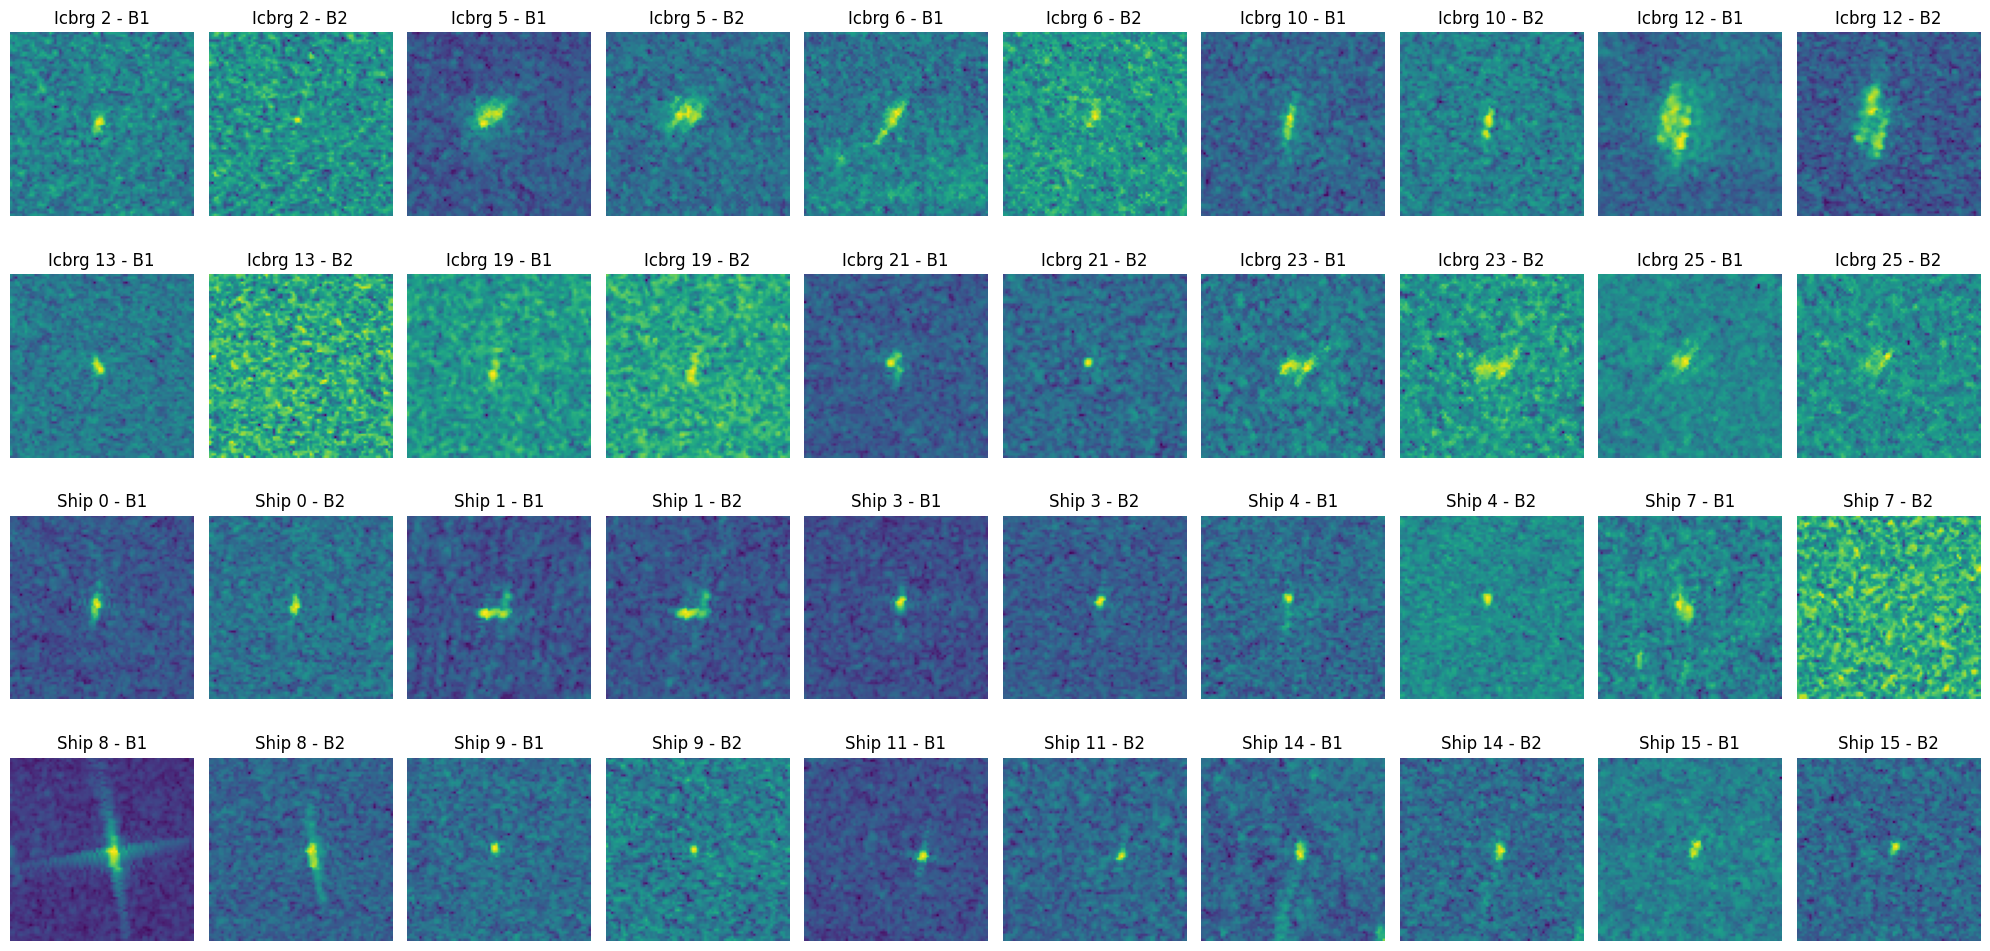

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 选择10个冰山样本和10个船只样本
icebergs = train[train['is_iceberg'] == 1].iloc[:10]
ships = train[train['is_iceberg'] == 0].iloc[:10]

# 设置画布大小
fig, axes = plt.subplots(4, 10, figsize=(20, 10))

# 绘制冰山样本
for i, (index, row) in enumerate(icebergs.iterrows()):
    # 获取band_1和band_2的数据
    band_1 = np.array(row['band_1']).reshape(75, 75)
    band_2 = np.array(row['band_2']).reshape(75, 75)
    
    # 绘制band_1图像
    ax = axes[i // 5, (i % 5) * 2]
    ax.imshow(band_1, cmap='viridis')
    ax.set_title(f'Icbrg {index} - B1')
    ax.axis('off')  # 不显示坐标轴
    
    # 绘制band_2图像
    ax = axes[i // 5, (i % 5) * 2 + 1]
    ax.imshow(band_2, cmap='viridis')
    ax.set_title(f'Icbrg {index} - B2')
    ax.axis('off')  # 不显示坐标轴

# 绘制船只样本
for i, (index, row) in enumerate(ships.iterrows()):
    # 获取band_1和band_2的数据
    band_1 = np.array(row['band_1']).reshape(75, 75)
    band_2 = np.array(row['band_2']).reshape(75, 75)
    
    # 绘制band_1图像
    ax = axes[i // 5 + 2, (i % 5) * 2]
    ax.imshow(band_1, cmap='viridis')
    ax.set_title(f'Ship {index} - B1')
    ax.axis('off')  # 不显示坐标轴
    
    # 绘制band_2图像
    ax = axes[i // 5 + 2, (i % 5) * 2 + 1]
    ax.imshow(band_2, cmap='viridis')
    ax.set_title(f'Ship {index} - B2')
    ax.axis('off')  # 不显示坐标轴

# 调整布局
plt.tight_layout()
plt.show()


# 随机森林分类器

训练过程：

构建多个决策树，每个决策树在不同的引导样本和特征子集上训练。
每个树在训练过程中尝试找到最佳分裂点，以最小化节点的不纯度（如Gini系数或信息增益）。
预测过程：

对于新的测试样本，所有决策树分别做出预测，结果是类别0或类别1。
通过多数投票法决定最终分类。如果树的预测是概率值，则可以取平均值并设置阈值（如0.5）进行分类。

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 加载和准备数据
train = pd.read_json("input/train.json")

X_band_1 = np.array([np.array(band).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).reshape(75, 75) for band in train['band_2']])

# 将数据展平成一维向量
X_band_1_flat = X_band_1.reshape((X_band_1.shape[0], -1))
X_band_2_flat = X_band_2.reshape((X_band_2.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_train = np.concatenate([X_band_1_flat, X_band_2_flat], axis=1)
y_train = np.array(train['is_iceberg'])

# 将数据集分成训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 训练随机森林分类器
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 在验证集上进行预测
y_pred = clf.predict(X_val)

# 计算准确率
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


# 加载测试数据
test = pd.read_json("input/test.json")

# 对测试数据进行预测，需要先将测试数据进行与训练数据相同的处理
X_test_band_1 = np.array([np.array(band).reshape(75, 75) for band in test['band_1']])
X_test_band_2 = np.array([np.array(band).reshape(75, 75) for band in test['band_2']])

# 将测试数据展平成一维向量
X_test_band_1_flat = X_test_band_1.reshape((X_test_band_1.shape[0], -1))
X_test_band_2_flat = X_test_band_2.reshape((X_test_band_2.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_test = np.concatenate([X_test_band_1_flat, X_test_band_2_flat], axis=1)

# 进行预测
predictions = clf.predict_proba(X_test)[:, 1]  # 取得冰山的概率值

# 生成输出文件
output_df = pd.DataFrame({
    'id': test['id'],
    'is_iceberg': predictions
})

# 将 DataFrame 写入 CSV 文件
output_file = 'predictions.csv'
output_df.to_csv(output_file, index=False)

print(f"Output file '{output_file}' generated successfully.")



Validation Accuracy: 71.65%
Output file 'predictions.csv' generated successfully.


Score: 0.51994

Public score: 0.52964

Rating: 2900+

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 加载和准备数据
train = pd.read_json("input/train.json")

X_band_1 = np.array([np.array(band).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).reshape(75, 75) for band in train['band_2']])

# 将数据展平成一维向量
X_band_1_flat = X_band_1.reshape((X_band_1.shape[0], -1))
X_band_2_flat = X_band_2.reshape((X_band_2.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_train = np.concatenate([X_band_1_flat, X_band_2_flat], axis=1)
y_train = np.array(train['is_iceberg'])

# 将数据集分成训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 训练随机森林分类器
clf = RandomForestClassifier(n_estimators=100, random_state=42,  criterion='entropy')
clf.fit(X_train, y_train)

# 在验证集上进行预测
y_pred = clf.predict(X_val)

# 计算准确率
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


# 加载测试数据
test = pd.read_json("input/test.json")

# 对测试数据进行预测，需要先将测试数据进行与训练数据相同的处理
X_test_band_1 = np.array([np.array(band).reshape(75, 75) for band in test['band_1']])
X_test_band_2 = np.array([np.array(band).reshape(75, 75) for band in test['band_2']])

# 将测试数据展平成一维向量
X_test_band_1_flat = X_test_band_1.reshape((X_test_band_1.shape[0], -1))
X_test_band_2_flat = X_test_band_2.reshape((X_test_band_2.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_test = np.concatenate([X_test_band_1_flat, X_test_band_2_flat], axis=1)

# 进行预测
predictions = clf.predict_proba(X_test)[:, 1]  # 取得冰山的概率值

# 生成输出文件
output_df = pd.DataFrame({
    'id': test['id'],
    'is_iceberg': predictions
})

# 将 DataFrame 写入 CSV 文件
output_file = 'predictions.csv'
output_df.to_csv(output_file, index=False)

print(f"Output file '{output_file}' generated successfully.")



Validation Accuracy: 75.08%
Output file 'predictions.csv' generated successfully.


Score: 0.51389

Private score: 0.50738

进步很小

Validation Accuracy: 71.65%
Output file 'predictions.csv' generated successfully.


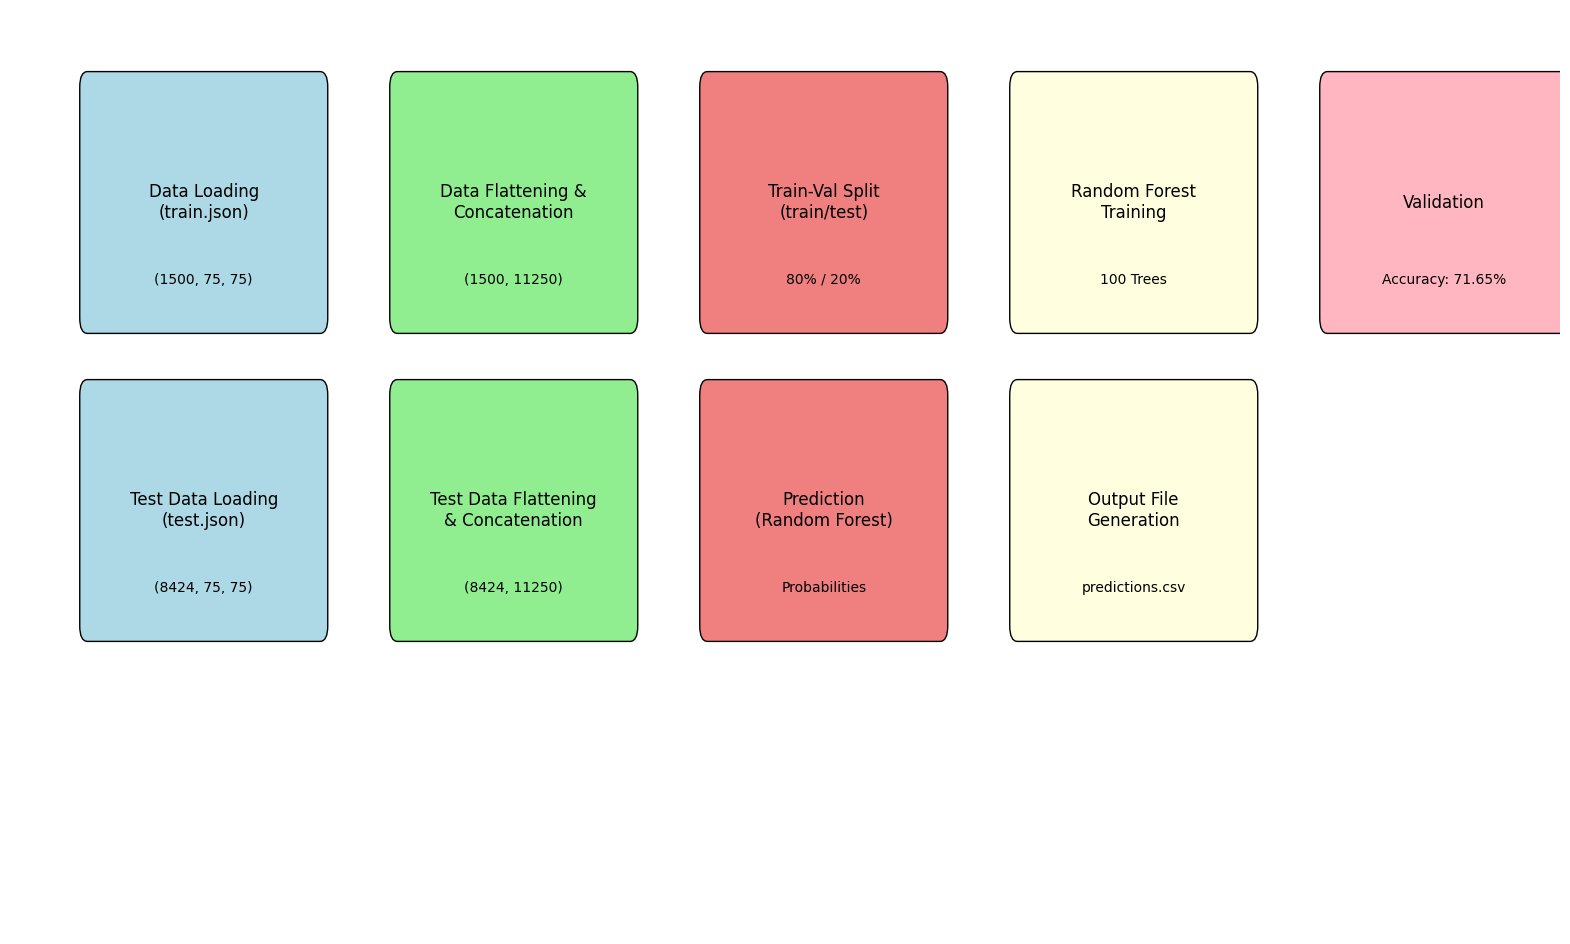

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 加载和准备数据
train = pd.read_json("input/train.json")

X_band_1 = np.array([np.array(band).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).reshape(75, 75) for band in train['band_2']])

# 将数据展平成一维向量
X_band_1_flat = X_band_1.reshape((X_band_1.shape[0], -1))
X_band_2_flat = X_band_2.reshape((X_band_2.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_train = np.concatenate([X_band_1_flat, X_band_2_flat], axis=1)
y_train = np.array(train['is_iceberg'])

# 将数据集分成训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 训练随机森林分类器
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 在验证集上进行预测
y_pred = clf.predict(X_val)

# 计算准确率
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


# 加载测试数据
test = pd.read_json("input/test.json")

# 对测试数据进行预测，需要先将测试数据进行与训练数据相同的处理
X_test_band_1 = np.array([np.array(band).reshape(75, 75) for band in test['band_1']])
X_test_band_2 = np.array([np.array(band).reshape(75, 75) for band in test['band_2']])

# 将测试数据展平成一维向量
X_test_band_1_flat = X_test_band_1.reshape((X_test_band_1.shape[0], -1))
X_test_band_2_flat = X_test_band_2.reshape((X_test_band_2.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_test = np.concatenate([X_test_band_1_flat, X_test_band_2_flat], axis=1)

# 进行预测
predictions = clf.predict_proba(X_test)[:, 1]  # 取得冰山的概率值

# 生成输出文件
output_df = pd.DataFrame({
    'id': test['id'],
    'is_iceberg': predictions
})

# 将 DataFrame 写入 CSV 文件
output_file = 'predictions.csv'
output_df.to_csv(output_file, index=False)

print(f"Output file '{output_file}' generated successfully.")


import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 初始化绘图
fig, ax = plt.subplots(figsize=(20, 12))

# 定义层的位置和大小
layer_width = 3
layer_height = 1.5

# 加载和准备数据层
data_loading_layer = patches.FancyBboxPatch((0, 5), layer_width, layer_height,
                                            boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightblue")
ax.add_patch(data_loading_layer)
ax.text(1.5, 5.75, 'Data Loading\n(train.json)', ha='center', va='center', fontsize=12)
ax.text(1.5, 5.25, '(1500, 75, 75)', ha='center', va='center', fontsize=10)

# 数据展平和合并层
data_flattening_layer = patches.FancyBboxPatch((4, 5), layer_width, layer_height,
                                               boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightgreen")
ax.add_patch(data_flattening_layer)
ax.text(5.5, 5.75, 'Data Flattening &\nConcatenation', ha='center', va='center', fontsize=12)
ax.text(5.5, 5.25, '(1500, 11250)', ha='center', va='center', fontsize=10)

# 训练和验证集划分层
train_val_split_layer = patches.FancyBboxPatch((8, 5), layer_width, layer_height,
                                               boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightcoral")
ax.add_patch(train_val_split_layer)
ax.text(9.5, 5.75, 'Train-Val Split\n(train/test)', ha='center', va='center', fontsize=12)
ax.text(9.5, 5.25, '80% / 20%', ha='center', va='center', fontsize=10)

# 训练随机森林层
training_layer = patches.FancyBboxPatch((12, 5), layer_width, layer_height,
                                        boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightyellow")
ax.add_patch(training_layer)
ax.text(13.5, 5.75, 'Random Forest\nTraining', ha='center', va='center', fontsize=12)
ax.text(13.5, 5.25, '100 Trees', ha='center', va='center', fontsize=10)

# 验证层
validation_layer = patches.FancyBboxPatch((16, 5), layer_width, layer_height,
                                          boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightpink")
ax.add_patch(validation_layer)
ax.text(17.5, 5.75, 'Validation', ha='center', va='center', fontsize=12)
ax.text(17.5, 5.25, 'Accuracy: {:.2f}%'.format(accuracy * 100), ha='center', va='center', fontsize=10)

# 测试数据加载和准备层
test_data_loading_layer = patches.FancyBboxPatch((0, 3), layer_width, layer_height,
                                                 boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightblue")
ax.add_patch(test_data_loading_layer)
ax.text(1.5, 3.75, 'Test Data Loading\n(test.json)', ha='center', va='center', fontsize=12)
ax.text(1.5, 3.25, '(8424, 75, 75)', ha='center', va='center', fontsize=10)

# 测试数据展平和合并层
test_data_flattening_layer = patches.FancyBboxPatch((4, 3), layer_width, layer_height,
                                                    boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightgreen")
ax.add_patch(test_data_flattening_layer)
ax.text(5.5, 3.75, 'Test Data Flattening\n& Concatenation', ha='center', va='center', fontsize=12)
ax.text(5.5, 3.25, '(8424, 11250)', ha='center', va='center', fontsize=10)

# 预测层
prediction_layer = patches.FancyBboxPatch((8, 3), layer_width, layer_height,
                                          boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightcoral")
ax.add_patch(prediction_layer)
ax.text(9.5, 3.75, 'Prediction\n(Random Forest)', ha='center', va='center', fontsize=12)
ax.text(9.5, 3.25, 'Probabilities', ha='center', va='center', fontsize=10)

# 输出文件生成层
output_layer = patches.FancyBboxPatch((12, 3), layer_width, layer_height,
                                      boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightyellow")
ax.add_patch(output_layer)
ax.text(13.5, 3.75, 'Output File\nGeneration', ha='center', va='center', fontsize=12)
ax.text(13.5, 3.25, 'predictions.csv', ha='center', va='center', fontsize=10)


# 调整图像范围
ax.set_xlim(-1, 19)
ax.set_ylim(1, 7)

# 移除坐标轴
ax.axis('off')

# 显示图像
plt.show()


# 简单卷积神经网络

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 加载和准备数据
train = pd.read_json("input/train.json")

X_band_1 = np.array([np.array(band).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).reshape(75, 75) for band in train['band_2']])
X_train = np.stack((X_band_1, X_band_2), axis=-1)  # 合并 band_1 和 band_2，并增加通道维度

y_train = np.array(train['is_iceberg'])

# 将数据集分成训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 构建卷积神经网络模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 2)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 编译模型
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 设置早停和模型保存的回调函数
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# 训练模型
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stop, model_checkpoint])

# 加载测试数据
test = pd.read_json("input/test.json")
X_test_band_1 = np.array([np.array(band).reshape(75, 75) for band in test['band_1']])
X_test_band_2 = np.array([np.array(band).reshape(75, 75) for band in test['band_2']])
X_test = np.stack((X_test_band_1, X_test_band_2), axis=-1)

# 进行预测
predictions = model.predict(X_test).flatten()

# 生成输出文件
output_df = pd.DataFrame({
    'id': test['id'],
    'is_iceberg': predictions
})

output_file = 'predictions_convolutions.csv'
output_df.to_csv(output_file, index=False)

print(f"Output file '{output_file}' generated successfully.")


Train on 1283 samples, validate on 321 samples
Epoch 1/20
1280/1283 [============================>.] - ETA: 0s - loss: 2.4402 - accuracy: 0.5273
Epoch 00001: val_accuracy improved from -inf to 0.48598, saving model to best_model.h5
1283/1283 [==============================] - 6s 5ms/sample - loss: 2.4358 - accuracy: 0.5277 - val_loss: 0.6261 - val_accuracy: 0.4860
Epoch 2/20
1280/1283 [============================>.] - ETA: 0s - loss: 0.5846 - accuracy: 0.6453
Epoch 00002: val_accuracy improved from 0.48598 to 0.50467, saving model to best_model.h5
1283/1283 [==============================] - 5s 4ms/sample - loss: 0.5844 - accuracy: 0.6454 - val_loss: 0.5943 - val_accuracy: 0.5047
Epoch 3/20
1280/1283 [============================>.] - ETA: 0s - loss: 0.5587 - accuracy: 0.6789
Epoch 00003: val_accuracy did not improve from 0.50467
1283/1283 [==============================] - 5s 4ms/sample - loss: 0.5575 - accuracy: 0.6797 - val_loss: 0.8798 - val_accuracy: 0.4891
Epoch 4/20
1280/1283 [

Score: 0.31582

Public score: 0.29287

Rating: 2500+

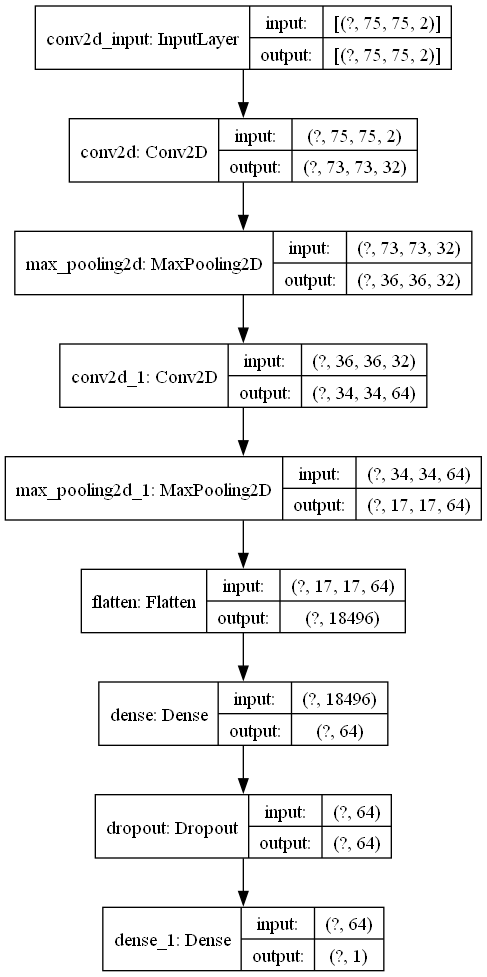

In [2]:
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 构建卷积神经网络模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 2)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),   
    Dense(1, activation='sigmoid')
])

# 保存模型结构图
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)


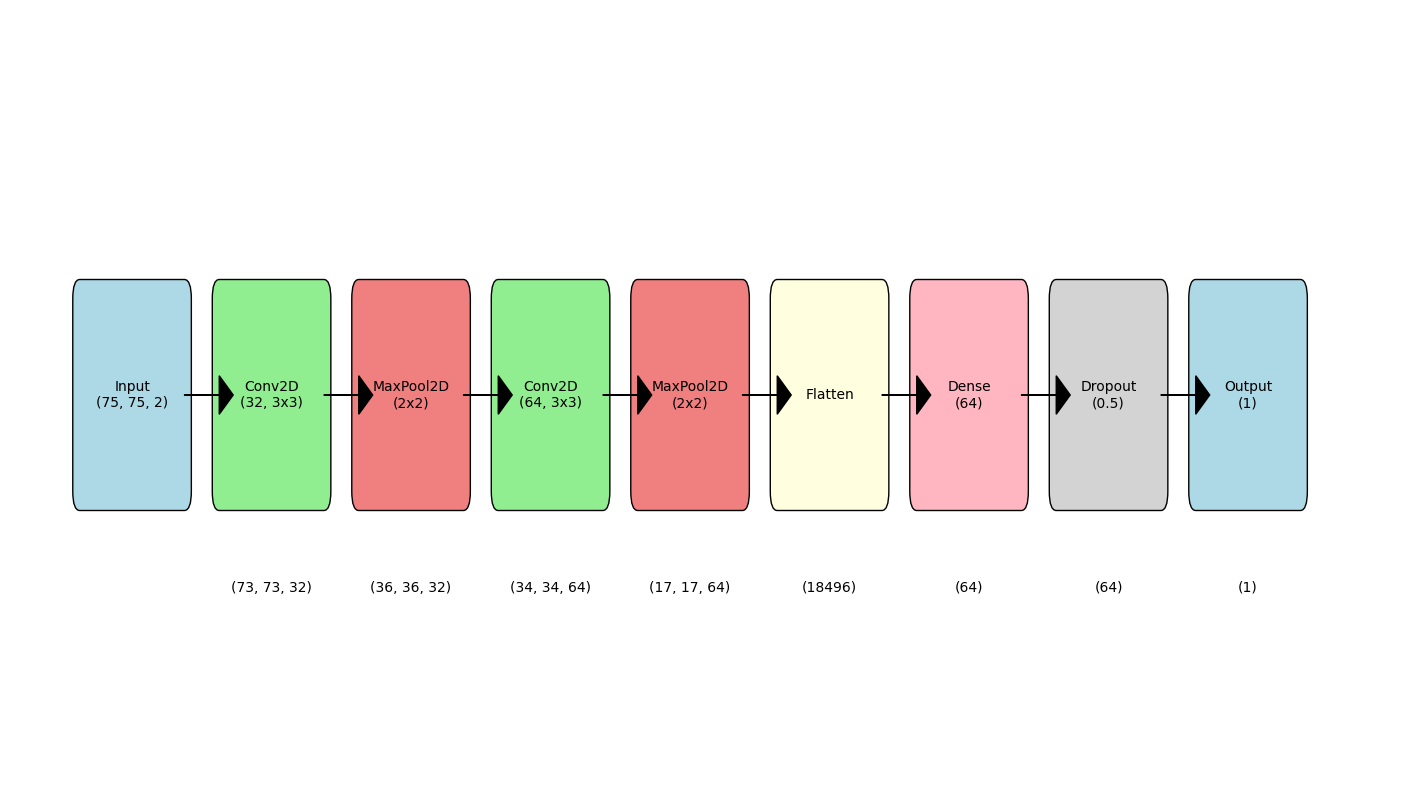

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 初始化绘图
fig, ax = plt.subplots(figsize=(18, 10))

# 定义层的位置和大小
layer_width = 1.5
layer_height = 1

# 输入层
input_layer = patches.FancyBboxPatch((0, 3.5), layer_width, layer_height,
                                     boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightblue")
ax.add_patch(input_layer)
ax.text(0.75, 4, 'Input\n(75, 75, 2)', ha='center', va='center', fontsize=10)

# 第一层卷积
conv1 = patches.FancyBboxPatch((2, 3.5), layer_width, layer_height,
                               boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightgreen")
ax.add_patch(conv1)
ax.text(2.75, 4, 'Conv2D\n(32, 3x3)', ha='center', va='center', fontsize=10)
ax.text(2.75, 3, '(73, 73, 32)', ha='center', va='center', fontsize=10)

# 第一层池化
pool1 = patches.FancyBboxPatch((4, 3.5), layer_width, layer_height,
                               boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightcoral")
ax.add_patch(pool1)
ax.text(4.75, 4, 'MaxPool2D\n(2x2)', ha='center', va='center', fontsize=10)
ax.text(4.75, 3, '(36, 36, 32)', ha='center', va='center', fontsize=10)

# 第二层卷积
conv2 = patches.FancyBboxPatch((6, 3.5), layer_width, layer_height,
                               boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightgreen")
ax.add_patch(conv2)
ax.text(6.75, 4, 'Conv2D\n(64, 3x3)', ha='center', va='center', fontsize=10)
ax.text(6.75, 3, '(34, 34, 64)', ha='center', va='center', fontsize=10)

# 第二层池化
pool2 = patches.FancyBboxPatch((8, 3.5), layer_width, layer_height,
                               boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightcoral")
ax.add_patch(pool2)
ax.text(8.75, 4, 'MaxPool2D\n(2x2)', ha='center', va='center', fontsize=10)
ax.text(8.75, 3, '(17, 17, 64)', ha='center', va='center', fontsize=10)

# 展平层
flatten = patches.FancyBboxPatch((10, 3.5), layer_width, layer_height,
                                 boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightyellow")
ax.add_patch(flatten)
ax.text(10.75, 4, 'Flatten', ha='center', va='center', fontsize=10)
ax.text(10.75, 3, '(18496)', ha='center', va='center', fontsize=10)

# 全连接层
dense1 = patches.FancyBboxPatch((12, 3.5), layer_width, layer_height,
                                boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightpink")
ax.add_patch(dense1)
ax.text(12.75, 4, 'Dense\n(64)', ha='center', va='center', fontsize=10)
ax.text(12.75, 3, '(64)', ha='center', va='center', fontsize=10)

# Dropout层
dropout = patches.FancyBboxPatch((14, 3.5), layer_width, layer_height,
                                 boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightgrey")
ax.add_patch(dropout)
ax.text(14.75, 4, 'Dropout\n(0.5)', ha='center', va='center', fontsize=10)
ax.text(14.75, 3, '(64)', ha='center', va='center', fontsize=10)

# 输出层
output_layer = patches.FancyBboxPatch((16, 3.5), layer_width, layer_height,
                                      boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightblue")
ax.add_patch(output_layer)
ax.text(16.75, 4, 'Output\n(1)', ha='center', va='center', fontsize=10)
ax.text(16.75, 3, '(1)', ha='center', va='center', fontsize=10)

# 添加箭头表示层间连接
for i in range(8):
    ax.arrow(i * 2 + 1.5, 4, 0.5, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')

# 调整图像范围
ax.set_xlim(-1, 19)
ax.set_ylim(2, 6)

# 移除坐标轴
ax.axis('off')

# 显示图像
plt.show()


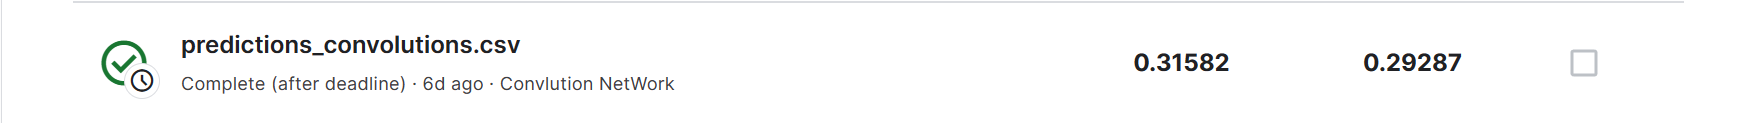